# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advanced DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.) to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
from torchvision import transforms

-----
## GPU Device Configuration
Use the torch.device() and torch.cuda.is_available() functions to make sure you can use the GPU

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = 'cpu'

print(device) #Check what device I am using

cuda


-----
## Configuration
### hyperparameters
We then set up the hyper parameters.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. number of epochs

In [3]:
#1. Learning Rate
learning_rate = 0.01

#2. Training Batch Size
train_batch_size = 20

#3. Testing Batch Size
test_batch_size = 20

#4. Number of Epochs
epochs = 50


Create a directory if it does not exist
you can use os.path.exists() to check whether it exists and using os.makedirs to create a directory.

-----
###  Image processing
Then, we define an image preprocessing object that our dataloader will use to preprocess our data. We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both the train set and test set. Note that for the test, we do not require any transform

In [4]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform positional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both the training split data loader and test split data loader

In [5]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


------
### Inception Module with dimension reductions
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. There are 4 Sequential blocks: b1,b2,b3,b4
    
    3. b1 is a block that consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    5. b3 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function: the forward function will forward the input function though every block and return the concatenation of all the output.

In [6]:
# For 3×3 kernels, use padding=1 to keep the output size equal to the input size.
# For 5×5 kernels, use padding=2 to keep the output size the same as the input size
# Tensor: [batch size, channels, height, width]
# Each self.b is a branch (small neural network) that takes in input vector and process it.

class Inception(nn.Module): #Inheriting nn.Module's base class.
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1), #2d convolution (1x1)
            nn.BatchNorm2d(kernel_1_x), #2d batch normalization
            nn.ReLU(True), #ReLU activation function
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1), #2d convolution (1x1)
            nn.BatchNorm2d(kernel_3_in),#2d batch normalization
            nn.ReLU(inplace=True), #ReLU activation function
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1), #2d convolution (3x3)
            nn.BatchNorm2d(kernel_3_x), #2d batch normalization
            nn.ReLU(inplace=True), #ReLU activation function
        )
        

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),#2d convolution (1x1)
            nn.BatchNorm2d(kernel_5_in), #2d batch normalization
            nn.ReLU(inplace = True), #ReLU activation function
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 2), #2d convolution (5x5)
            nn.BatchNorm2d(kernel_5_x), #2d batch normalization
            nn.ReLU(inplace = True), #ReLU activation function
        )
        
        # 3x3 max pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1), #Maxpooling (3x3)
            nn.Conv2d(in_planes, pool_planes, kernel_size = 1), #2d convolution (1x1)
            nn.BatchNorm2d(pool_planes),#2d batch normalization
            nn.ReLU(inplace = True), #ReLU activation function
        )

    def forward(self, x): #This is called when InceptionBlock(x).
        
        #Each block computed in parallel.
        b1_out = self.b1(x)
        b2_out = self.b2(x)
        b3_out = self.b3(x)
        b4_out = self.b4(x)
        
        output = torch.cat([b1_out, b2_out, b3_out, b4_out], dim = 1) #Concatenate along dim = 1 (channel)
        
        return output

-----
### GoogLeNet Module: the structure is in the lab manual

In [7]:
#first layer: Conv2d (3->192), 3*3: 3 input channels, 192 output channel (192 filters), 3x3 kernel
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        self.conv = nn.Conv2d(3, 192, kernel_size = 3, padding = 1)
        self.bn = nn.BatchNorm2d(192)
        self.relu = nn.ReLU(inplace = True)
        
        #self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes
        self.inception1 = Inception(192, 64, 96, 128, 16, 32, 32) #branch1: 64 channels, branch2: 128 channels, branch3: 32 channels, branch4: 32 channels. After concatenation, 64+128+32+32 = 256 channels.
        self.inception2 = Inception(256, 128, 128, 192, 32, 96, 64) #branch1: 128 channels, branch2: 192, branch3, 96, branch4: 64. After concatenation, 128+192+96+64 = 480 channels.
        
        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1) #since stride = 2, it is halving the input spatial dimensions.
        
        self.inception3 = Inception(480, 192, 96, 208, 16, 48, 64) #branch1: 192 channels, branch2: 208, branch3:48, branch4:64. After concatenation, 192+208+48+64 = 512
        self.inception4 = Inception(512, 160, 112, 224, 24, 64, 64) #branch1: 160, branch2:224, bracnh3:64, branch4: 64. After concatenation, 160+224+64+64 = 512
        self.inception5 = Inception(512, 128, 128, 256, 24, 64, 64) #branch1: 128, branch2: 256, branch3:64, branch4: 64. After concatenation, 128+256+64+64 = 
        self.inception6 = Inception(512, 112, 144, 288, 32, 64, 64) #branch1: 112, branch2:288, branch3:64, branch4: 64 After concatenation, 112+288+64+64 = 528
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128) #branch1: 256, branch2: 320, branch3: 128, branch4: 128. After concatenation 256+320+128+128  =
        
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.inception8 = Inception(832, 256, 160, 320, 32, 128, 128) #branch1: 256, branch2:320, branch3:128, branch4:128. After concatenation: 256+320+128+128 = 832
        self.inception9 = Inception(832, 384, 192, 384, 48, 128, 128) #branch1: 384, branch2:384, branch3:128, branch4: 128. After concatenation: 384+348+128+128 = 1024
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1,1)) # [B, 1024, H, W] => [B, 1024, 1, 1]
        self.flatten = nn.Flatten(start_dim = 1) # [B, 1024, 1, 1] => [B, 1024]
        self.fc = nn.Linear(1024, 10)
        
    
    def forward(self, x):
        
        #Passing input x in order of the architecture.
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.inception1(x)
        x = self.inception2(x)
        
        x = self.maxpool1(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        
        x = self.maxpool2(x)
        
        x = self.inception8(x)
        x = self.inception9(x)
        
        x = self.avgpool1(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

### Next, we create the network and send it to the target device

In [8]:
model = GoogLeNet()
model = model.to(device) # Need to have model and inputs in the same device

### Finally, we create:
 1. An optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [9]:
#Adam Optimizer in pytorch
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
#Criterion = loss function in pytorch
criterion = nn.CrossEntropyLoss()

In [11]:
#Scheduler. The scheduler that matches the description is MultiStepLR

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones = [10, 20, 40], #Update the learning rate when epochs reach this milestone.
    gamma = 0.1,
)


-----
##  Training
Then, we are going to train our Network

1. Set our network to the training mode.
2. Initialize the train loss, total data size, and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backpropagate the loss
    6. Update the network parameters using the optimizier
    7. Accumulate the training loss
    8. Find the prediction. hint: using torch.max()
    9. Increment the total_data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Initialize the test loss, total data size, and number corrected predictions. 
3. For each data in the testing split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the testing loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. Train the model
2. Step the scheduler
3. Test our model
4. Update the accuracies
5. Save the module at the end and print the accuracy

In [12]:
test_losses = [] #Array to store test losses for loss plot.
test_accuracies = [] #Array to store test accuracies for accuracy plot.

#1. Train the model
for epoch in range(epochs): #For each epoch
    model.train() #Set the network into training mode

    train_loss = 0.0 #Initialize the train loss, total data size, and number of correct predictions
    total_data = 0
    correct_preds = 0
    
    for batch in train_loader: #Looping through each training data split
        inputs, labels = batch
        
        inputs = inputs.to(device) #Put the data into the correct device (from CPU to GPU)
        labels = labels.to(device)

        optimizer.zero_grad() #Reset the gradients of the optimizer (pytorch automatically accumulates gradients, so reset before backprop)

        predictions = model(inputs) #Feed the data forward to the model (forward pass)

        loss = criterion(predictions, labels) #Use the criterion function to compute the loss

        loss.backward() #Backpropagate the loss (backward pass to calculate gradients to optimize the parameters)
        
        optimizer.step() #Update the network parameters using the optimizer

        train_loss += loss.item() * inputs.size(0) #Accumulate the training loss. Batch loss = average loss * # of inputs

        _, predicted_class = torch.max(predictions, dim = 1) #Find the prediction. Getting the max for each sample.
        
        total_data += labels.size(0) #Increment the total data size and correct predictions
        correct_preds += (predicted_class == labels).sum().item()
    
    
    train_avg_loss = train_loss / total_data #Calculate avg_loss
    train_accuracy = correct_preds / total_data #Calculate accuracy
    
    #Step 2. Step the scheduler
    scheduler.step()
    
    #Step 3. Test the model
    model.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    #For each data in the testing split, we warp it using torch.no_grad()

    with torch.no_grad(): #Make sure gradient is not accumulated while evaluating the model.
        
        for inputs, labels in test_loader: #Looping through each training data split.
            inputs = inputs.to(device) #Put the data to the correct device (CPU to GPU).
            labels = labels.to(device)
            
            predictions = model(inputs) #Make prediction by passing input to model.
            
            loss = criterion(predictions, labels) #Use the criterion function to compute the loss term.
            
            test_loss += loss.item() * inputs.size(0) #Accumulate the testing loss.
            
            _, predicted_class = torch.max(predictions, dim = 1) #Find the prediction.
            
            test_total += labels.size(0) #Increment total amount of data.
            test_correct += (predicted_class == labels).sum().item() #Increment the corrected prediction.
    
    #Step 4. Update the accuracies
    test_avg_loss = test_loss / test_total
    test_losses.append(test_avg_loss)
    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    #Step 5. Save the module at the end and print the accuracy
    torch.save(model.state_dict(), 'model.pth')
    
    #Print training and test log.
    print(f"Epoch: {epoch} | Training loss: {train_avg_loss:.3f} | Training accuracy: {train_accuracy:.3f} | Testing loss: {test_avg_loss:.3f} | Testing accuracy: {test_accuracy:.3f}")

Epoch: 0 | Training loss: 1.664 | Training accuracy: 0.381 | Testing loss: 1.255 | Testing accuracy: 0.537
Epoch: 1 | Training loss: 1.053 | Training accuracy: 0.624 | Testing loss: 0.938 | Testing accuracy: 0.670
Epoch: 2 | Training loss: 0.778 | Training accuracy: 0.730 | Testing loss: 0.857 | Testing accuracy: 0.706
Epoch: 3 | Training loss: 0.641 | Training accuracy: 0.780 | Testing loss: 0.620 | Testing accuracy: 0.786
Epoch: 4 | Training loss: 0.554 | Training accuracy: 0.809 | Testing loss: 0.570 | Testing accuracy: 0.804
Epoch: 5 | Training loss: 0.491 | Training accuracy: 0.830 | Testing loss: 0.590 | Testing accuracy: 0.803
Epoch: 6 | Training loss: 0.434 | Training accuracy: 0.851 | Testing loss: 0.559 | Testing accuracy: 0.812
Epoch: 7 | Training loss: 0.390 | Training accuracy: 0.866 | Testing loss: 0.504 | Testing accuracy: 0.828
Epoch: 8 | Training loss: 0.360 | Training accuracy: 0.874 | Testing loss: 0.477 | Testing accuracy: 0.842
Epoch: 9 | Training loss: 0.322 | Tra

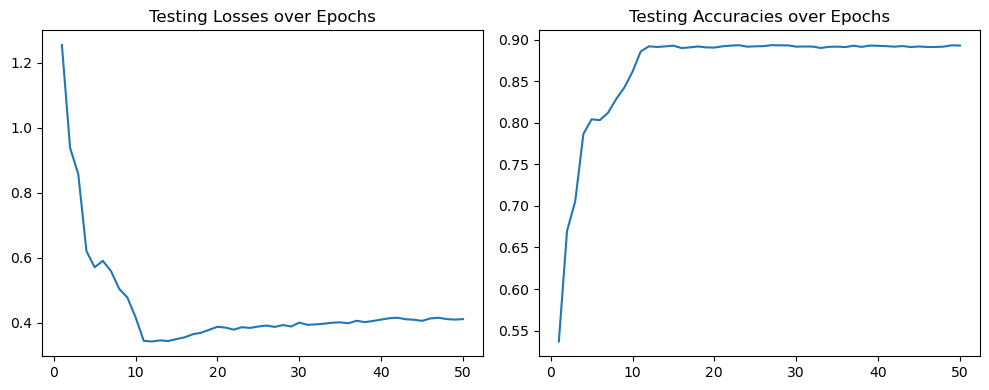

In [14]:
import matplotlib.pyplot as plt

epochs_list = np.arange(start = 1, stop = epochs + 1) #Creating a list of epochs

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) #Create subplots of row = 1, column = 2

ax1.plot(epochs_list, test_losses) #Plot Epochs vs Testing Losses
ax1.set_title("Testing Losses over Epochs")

ax2.plot(epochs_list, test_accuracies) #Plot Epochs vs Testing Accuracies
ax2.set_title("Testing Accuracies over Epochs")

plt.tight_layout()
plt.show()